In [22]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hypertools as hyp
import quail
from scipy.stats import pearsonr as corr
from scipy.stats import sem
from scipy.signal import resample

%matplotlib inline
sns.set_context('poster')
sns.set_style('ticks')
plt.rc('figure', figsize=(12, 8))

In [2]:
rawdir = '../../data/raw/'
datadir = '../../data/processed/'

In [3]:
# load in raw annotation file
movie_annotations = pd.read_excel(rawdir+'Sherlock_Segments_1000_NN_2017.xlsx')
movie_annotations['Scene Segments'].fillna(method='ffill', inplace=True)

In [4]:
# model parameters
ntopics = 100
m_wsize = 50
r_wsize = 10

# vectorizer parameters
vectorizer = {
    'model' : 'CountVectorizer', 
    'params' : {
        'stop_words' : 'english'
    }
}

# topic model parameters
semantic = {
    'model' : 'LatentDirichletAllocation', 
    'params' : {
        'n_components' : ntopics,
        'learning_method' : 'batch',
        'random_state' : 0
    }
}

## define some functions

In [5]:
def model_movie(movie_df, w_size, vec_params, sem_params):
    
    # create list of text samples from annotations
    movie_text = movie_df.apply(lambda x: ','.join(x.fillna('')), axis=1).values.tolist()

    # create sliding window of text samples
    movie_windows = []
    for idx, sentence in enumerate(movie_text):
        movie_windows.append(','.join(movie_text[idx:idx+m_wsize]))

    # vectorizer and topic model parameters
    vectorizer = vec_params
    semantic = sem_params

    # use hypertools to create movie model
    movie_model = hyp.tools.format_data(movie_windows, vectorizer=vec_params, semantic=sem_params, corpus=movie_windows)[0]

    # scene description are by shot, not TR, so stretch the model to be in TRs
    ranges =[[d['Start Time (TRs, 1.5s)'],d['End Time (TRs, 1.5s)']] for i, d in movie_annotations.iterrows()] 
    expanded = []
    for i in range(1976):
        try:
            idx = np.where([i>=r[0] and i<=r[1] for r in ranges])[0][0]
            expanded.append(movie_model[idx, :])
        except:
            expanded.append(movie_model[0, :])
    
    # return stretched model and make movie windows accessible for modeling recall
    return np.array(expanded), movie_windows

In [6]:
def model_recall(sub, w_size, vec_params, sem_params, corpus):
    
    # load recall from text file
    recall = pd.read_csv(rawdir+'NN'+str(sub)+' transcript.txt', header=None, sep='.', error_bad_lines=False, encoding='latin-1').values.tolist()[0][:-1]
    
    sent = []
    # separate sentences
    for sentence in recall:
        try:
            s = sentence.encode('utf-8').strip()
            sent.append(sentence)
        except AttributeError:
            pass # skip over NaNs
        
    # create sliding window of sentences
    recall_windows = []
    for idx, s in enumerate(sent):
        recall_windows.append(','.join(sent[idx:idx+r_wsize]))
    
    # use hypertools to create recall model
    recall_model = hyp.tools.format_data(recall_windows, vectorizer=vec_params, semantic=sem_params, corpus=corpus)
    
    # resample model to match sherlock movie model
    return resample(recall_model[0], 1976)

In [7]:
# creates a list of subjects' recall models
def model_all_subs(subs, w_size, vec_params, sem_params, corpus):
    return [model_recall(sub, w_size, vec_params, sem_params, corpus) for sub in subs]

In [8]:
# drop a single feature from the model
def drop_feature(df, feature):
    return df.drop(feature, axis=1)

# computes correlation between movie model and recall model and standard error
def compare_mr_models(m_model, r_model):
    return corr(pd.DataFrame(m_model).T.corr().values.ravel(), pd.DataFrame(r_model).T.corr().values.ravel())[0]

## Which features are important to the movie/recall model relationship?

In [9]:
# load in full movie model and resampled recall models
full_movie_model = np.load(datadir+'models_t100_v50_r10_resampled.npy')[0]
full_recall_models_rs = np.load(datadir+'models_t100_v50_r10_resampled.npy')[1]

In [10]:
# isolate features used in model
features_df = movie_annotations.loc[:,'Scene Details - A Level ':'Words on Screen ']
features_df.columns = ['Narrative Details', 'Indoor vs Outdoor', 'Characters on Screen', 'Character in Focus', 
                       'Character Speaking', 'Location', 'Camera Angle', 'Music Presence', 'Text on Screen']

In [11]:
allsubs = [sub for sub in range(1,18)]
dropfeat_corrs = {}
standard_errors = {}

# compute average recall model correlation to full movie model and average standard error
corrs_full = [compare_mr_models(full_movie_model, full_recall_models_rs[sub]) for sub in range(17)]
avg_corr_full = np.mean([r for r in corrs_full])
SE_full = sem(corrs_full)
print('with all features, correlation is ' + str(avg_corr_full) + ', standard error is ' + str(SE_full))
dropfeat_corrs['Full Model'] = avg_corr_full
standard_errors['Full Model'] = SE_full

# iteratively leave out one feature from model and recompute correlation
for feat in features_df.columns:
    print('\ndropping '+str(feat))
    partial_df = drop_feature(features_df,feat)
    
    # model partial movie features
    print('computing movie model')
    m_model_with_windows = model_movie(partial_df, m_wsize, vectorizer, semantic)
    partial_movie_model = m_model_with_windows[0]
    
    # remodel recalls based on partial movie model windows
    print('computing recall models')
    recall_models = model_all_subs(allsubs, r_wsize, vectorizer, semantic, m_model_with_windows[1])
    
    # correlate each recall model to the movie model
    sub_corrs = []
    for rec_mod in recall_models:
        r = (compare_mr_models(partial_movie_model, rec_mod))
        sub_corrs.append(r)

    # compute mean correaltion and standard error
    feat_corr = np.mean(sub_corrs)
    feat_se = sem(sub_corrs)
    print('avg correlation is '+ str(feat_corr))
    print('standard error is '+ str(feat_se))
    dropfeat_corrs[feat] = feat_corr
    standard_errors[feat] = feat_se
    
    # save out partial movie and recall models
    print('saving partial models')
    np.save(datadir+'dropfeat_models/%s_dropped_models' % (str(feat)), [partial_movie_model, recall_models])

with all features, correlation is 0.6280980859010863, standard error is 0.01115385259393097

dropping Narrative Details
computing movie model
computing recall models
avg correlation is 0.464799291277212
standard error is 0.01767904009551159
saving partial models

dropping Indoor vs Outdoor
computing movie model
computing recall models
avg correlation is 0.6355581177914257
standard error is 0.009303249234474655
saving partial models

dropping Characters on Screen
computing movie model
computing recall models
avg correlation is 0.6438028594688109
standard error is 0.010528891113398988
saving partial models

dropping Character in Focus
computing movie model
computing recall models
avg correlation is 0.6370501016759813
standard error is 0.010861663192204545
saving partial models

dropping Character Speaking
computing movie model
computing recall models
avg correlation is 0.621218289752842
standard error is 0.008830722653226656
saving partial models

dropping Location
computing movie model


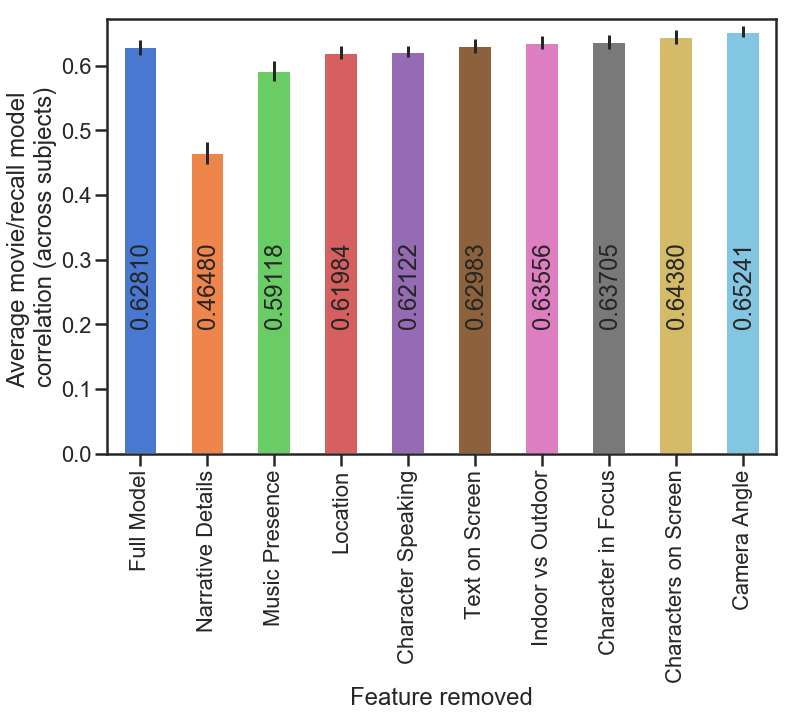

In [23]:
# plot correlations
sns.set_palette('muted')
order = order = ['Full Model','Narrative Details','Music Presence', 'Location','Character Speaking','Text on Screen',
                 'Indoor vs Outdoor','Character in Focus','Characters on Screen','Camera Angle']

series_ord = pd.Series(dropfeat_corrs).reindex(order)

series_ord.plot(kind='bar', ylim=[0,series_ord['Camera Angle']+.02], yerr=pd.Series(standard_errors))

plt.ylabel('Average movie/recall model \ncorrelation (across subjects)')
plt.xlabel('Feature removed')

for idx, corr in enumerate(series_ord.values):
    plt.text(idx-.15, 0.3, '%.5f'%corr, rotation=90)
    
plt.savefig('../../paper/figs/5_dropfeat_m_r_corr.pdf', bbox_inches='tight')